### Script to generate FATES parameters using LHS

In [1]:
from scipy.stats import qmc
import numpy as np
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re
import modp as mp
from matplotlib import pyplot as plt
from scipy.io import netcdf as nc

### Read in min and max values for each parameter and pft 
- Adapted from work by Rachel Ward (parameter ranges and inequalities). 
- Where there are inequalities between PFTx and PFTy, sample PFTx parameter and then use a scalar to generate PFTy parameter. -- If parameter ranges are the same ignore the inequality
- Add some noise to the inequalities so that inter-PFT trait correlations are not too strict

In [2]:
param_ranges_full = pd.read_csv('/glade/u/home/adamhb/california-fates/parameter_ranges/param_ranges_conifer_allom_test_090123.csv')
param_ranges = param_ranges_full[['param', 'value_min', 'value_max', 'pft', 'organ']]

# number of parameters
n_params = len(param_ranges)
print("Number of params:",n_params)

# number of PFTs - some are global so subtract one
n_pfts = max(len(pd.unique(param_ranges['pft'])) - 1, 1)
print("Number of pfts:", n_pfts)

param_names = list(param_ranges.param)
print("Param names:",param_names)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

print("\n")
print("Param ranges")
print(param_ranges)

Number of params: 2
Number of pfts: 1
Param names: ['fates_allom_d2ca_coefficient_min', 'fates_leaf_vcmax25top']


Param ranges
                              param  value_min  value_max  pft  organ
0  fates_allom_d2ca_coefficient_min      0.257       0.37    1    NaN
1             fates_leaf_vcmax25top     48.000      76.00    1    NaN


### Sample the parameter space using a Latin Hypercube approach

In [3]:
n_inst = 36

sampler = qmc.LatinHypercube(d=n_params, seed=31)
sample = sampler.random(n=n_inst)

# scale to parameter ranges
l_bounds = param_ranges['value_min']
u_bounds = param_ranges['value_max']

scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

print("ensemble dimensions:",scaled_sample.shape)

#Create a dataframe of the LHS ensemble
col_names = [v + "_" + str(p) for v,p in zip(param_names,pfts)]
lhs_df = pd.DataFrame(data=scaled_sample,columns=col_names)

ensemble dimensions: (36, 2)


### Visualize distribution of parameter ranges sampled by the LHS

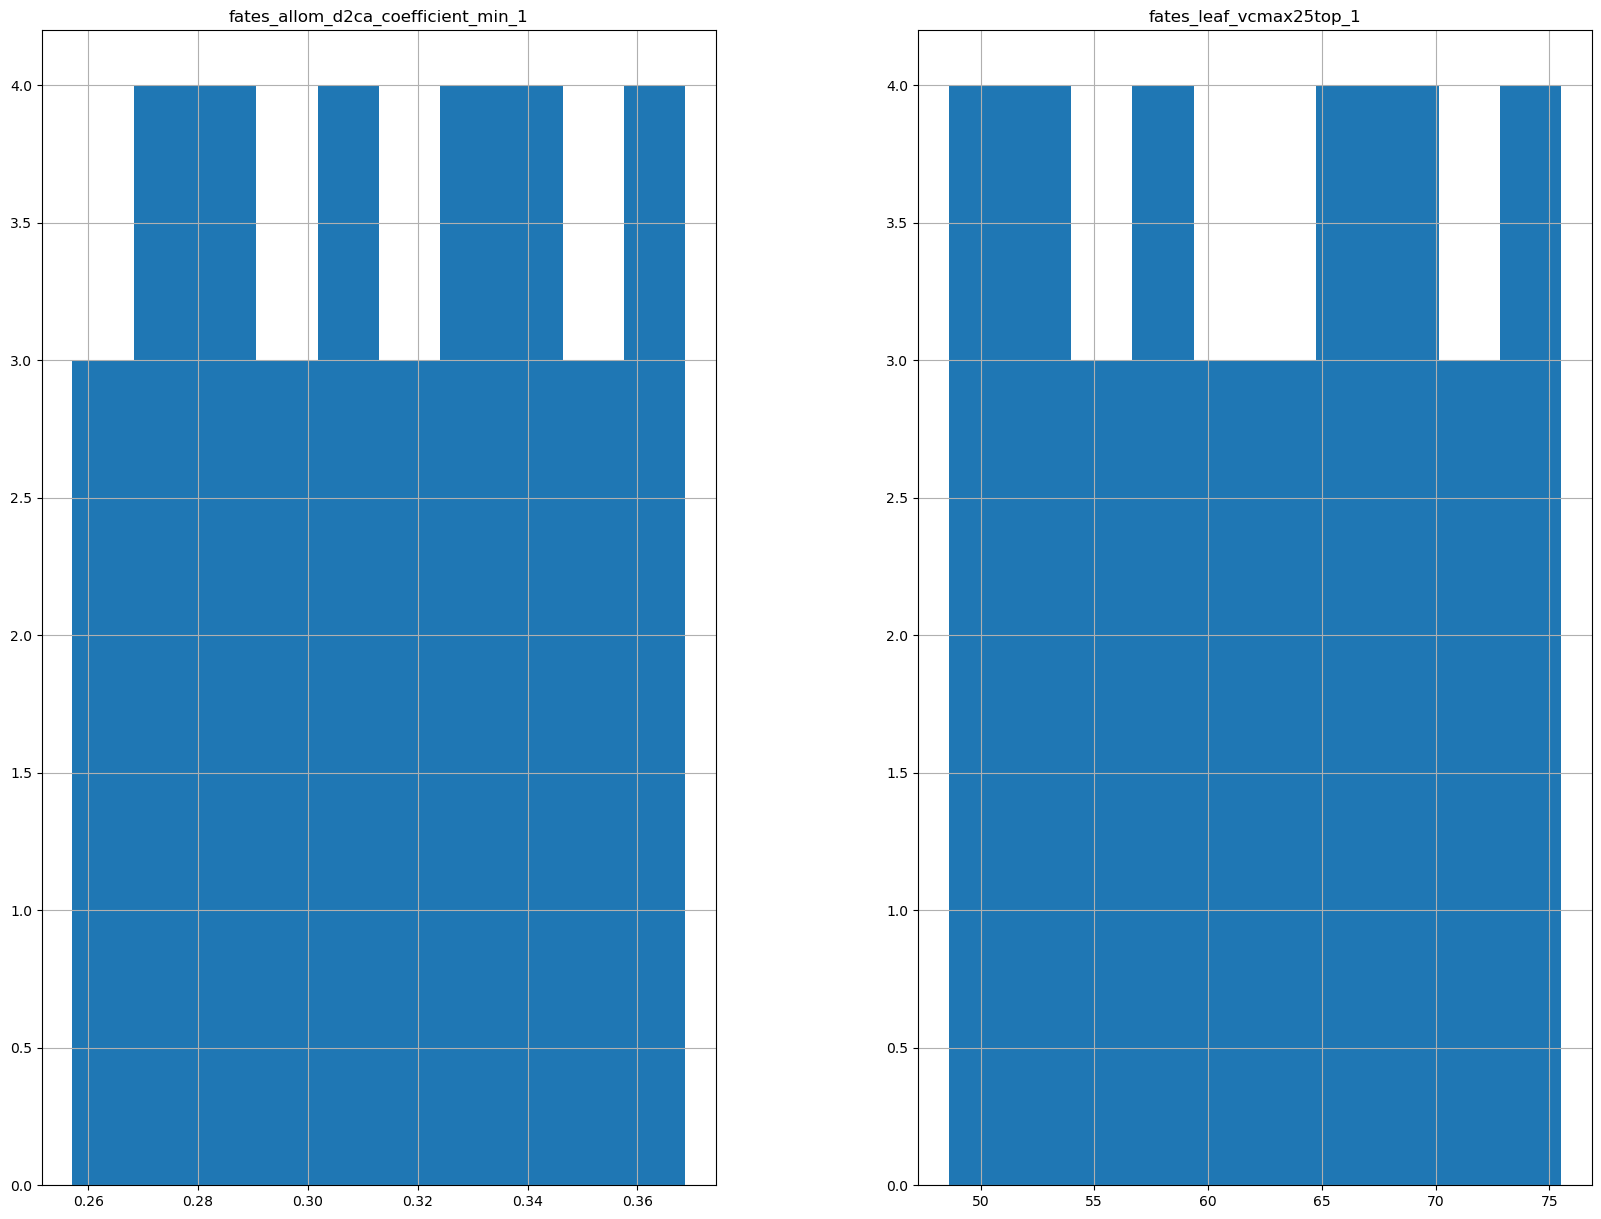

In [4]:
if lhs_df.shape[1] < 50:
   lhs_df.hist(bins=10, figsize=(20,15))
   plt.show()

### Some parameters are held equal for all conifers

There are some parameters that we keep equal among the conifers. We want the value pulled for pine from the Latin hypercube to apply to all conifers.

In [ ]:
#equal_among_conifers = ["fates_recruit_seed_alloc_mature"]

### Construct parameter files from the LHS samples

In [5]:
## Read in FATES file with values that will be used for all non-varying parameters

# This parameter file has many changes associated with it compared to the default FATES file
# It also has new parameter added as part of the development required for this experiment.
input_fname = '/glade/u/home/adamhb/ahb_params/fates_api_25/ca_ahb_5pfts_090123_conifer_only.nc'

# for each sample 
for i in range(0,n_inst) :
    
    param_file_end = str(i+1).rjust(4, '0')
    
    print(param_file_end)
    
    # final parameter file name
    fout = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/conifer_allom_090123/conifer_allom_090123_{0}.nc'.format(param_file_end)
    
    shutil.copyfile(input_fname, fout)                                                                                                                             
   
    # loop through each parameter and apply either to the correct pft or globally
    for j in range(0, n_params) : 
        
        var = param_names[j]
        pft = pfts[j]
        organ = organs[j]
        
        val = scaled_sample[i, j]
        
        mp.main(var = var, pft = pft, fin = fout, val = val, 
                    fout = fout, O = 1, organ = organ)
        mp.main(var = var, pft = pft + 1, fin = fout, val = val, 
                    fout = fout, O = 1, organ = organ)
        mp.main(var = var, pft = pft + 2, fin = fout, val = val, 
                    fout = fout, O = 1, organ = organ)
        # mp.main(var = var, pft = pft + 3, fin = fout, val = val, 
        #             fout = fout, O = 1, organ = organ)
        
        
        #also change d2ca max to same value as min
        if var == 'fates_allom_d2ca_coefficient_min':
            
            true_var = var
            tmp_var = 'fates_allom_d2ca_coefficient_max'
            
            mp.main(var = tmp_var, pft = pft, fin = fout, val = val, 
                        fout = fout, O = 1, organ = organ)
            mp.main(var = tmp_var, pft = pft + 1, fin = fout, val = val, 
                        fout = fout, O = 1, organ = organ)
            mp.main(var = tmp_var, pft = pft + 2, fin = fout, val = val, 
                        fout = fout, O = 1, organ = organ)
            # mp.main(var = tmp_var, pft = pft + 3, fin = fout, val = val, 
            #             fout = fout, O = 1, organ = organ)
        
        
        
        if var == 'fates_leaf_vcmax25top': 
            
            new_val = val * (49/57)
            mp.main(var = var, pft = 2, fin = fout, val = new_val, 
                    fout = fout, O = 1, organ = organ)
            
            new_val = val * (37/57)
            mp.main(var = var, pft = 3, fin = fout, val = new_val, 
                    fout = fout, O = 1, organ = organ)
        
        #add trait inequalities
        ## pick up here with a good way of adding trait inqualities and
        ## adding code to have some conifer variables vary together
        
        #shrub vcmax should always be higher than pine vcmax
#         if var == 'fates_leaf_vcmax25top' and pft == 1 : 
#             pft = pft + 3
#             val = val * 0.75
#             mp.main(var = var, pft = pft, fin = fout, val = val, 
#                     fout = fout, O = 1, organ = organ)
            
       
            
#         if var == 'fates_leaf_vcmax25top' and pft == 1 : 
#             pft = pft + 1
#             val = val * 0.9
#             mp.main(var = var, pft = pft, fin = fout, val = val, 
#                     fout = fout, O = 1, organ = organ)
            
            
        #parameters that vary as a group (i.e. conifers)
        # if var in equal_among_conifers and pft == 1 :
        #     for p in np.array([1,2]):
        #         pft = p
        #         mp.main(var = var, pft = p, fin = fout, val = val, 
        #             fout = fout, O = 1, organ = organ)

0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036


### Check the variable values in the parameter files

In [19]:
def extract_variable_from_netcdf(file_path, variable_name):
    """
    Extract a variable from a NetCDF file.

    Parameters:
    - file_path: The path to the NetCDF file.
    - variable_name: The name of the variable to extract.

    Returns:
    - The extracted variable data.
    """
    with nc4.Dataset(file_path, 'r') as dataset:
        # Check if the variable exists in the dataset
        if variable_name in dataset.variables:
            variable_data = dataset.variables[variable_name][:]
            return variable_data
        else:
            raise ValueError(f"'{variable_name}' not found in the NetCDF file.")

# Usage
file_path = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/conifer_allom_083023/conifer_allom_083023_0006.nc'
variable_name = 'fates_leaf_vcmax25top'
#variable_name = 'fates_allom_d2ca_coefficient_max'
data = extract_variable_from_netcdf(file_path, variable_name)
#dim: (organ,pft)
print(data[0,:])
print(len(data.shape))

[60.45702073 51.97182484 39.244031  ]
2
